Model training, hyper-parameter tuning and cross-validation

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# load adhd dataset
df = pd.read_csv('questionnaire_dataset.csv', sep=';')
feature_cols = desired_columns = ['gender', 'group'] + [f'tr{i}' for i in range(1, 44)] + [f'dass{i}' for i in range(1, 22)]
df = df[feature_cols].copy()

Screening questionnaire (feature selection)

In [3]:
# load the screening questionnaire 
screening_questions = pd.read_csv('screening_questions.csv', sep=';')
screening_questions

,Critère DSM-5,English Item (Author's suggestion),question_code,dsm5_criteria,symptom_category
0,A,I don't really pay attention to details,tr1,Often fails to give close attention to details...,inattention
1,A,I often make careless mistakes in my activities,tr3,Often fails to give close attention to details...,inattention
2,B,I have trouble maintaining my attention at work.,tr4,Often has difficulty sustaining attention in t...,inattention
3,B,I have trouble staying focused during conversa...,tr6,Often has difficulty sustaining attention in t...,inattention
4,C,"My mind is often elsewhere, even when there is...",tr8,Often does not seem to listen when spoken to d...,inattention
5,D,I have difficulty complying with instructions,tr9,Often does not follow through on instructions ...,inattention
6,D,I have difficulty staying focused during my ac...,tr11,Often does not follow through on instructions ...,inattention
7,E,My work is often messy or disorganized,tr13,Often has difficulty organizing tasks and acti...,inattention
8,F,I tend to operate at the last minute,tr17,"Often avoids, dislikes, or is reluctant to eng...",inattention
9,G (I),I often lose things I need for my daily life,tr18,Often loses things necessary for tasks or acti...,inattention


Data preprocessing

In [5]:
adasyn = ADASYN(random_state=38)
X = df.copy().drop(columns=['gender'])
y = df['gender'].copy() # men = 1 / women = 0
X_balanced, y_balanced = adasyn.fit_resample(X, y)
balanced_df = pd.concat([y_balanced, X_balanced], axis=1)
balanced_df.describe()

,gender,group,tr1,tr2,tr3,tr4,tr5,tr6,tr7,tr8,...,dass12,dass13,dass14,dass15,dass16,dass17,dass18,dass19,dass20,dass21
count,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,...,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000
mean,0.502809,0.457865,3.542135,3.702247,4.794944,4.379213,3.870787,3.735955,3.292135,4.308989,...,1.553371,1.390449,1.294944,0.988764,0.761236,1.415730,1.595506,1.109551,1.033708,1.176966
std,0.500696,0.498923,1.587245,1.536814,1.430090,1.470658,1.581634,1.652297,1.693083,1.622041,...,1.020889,0.879705,0.961265,0.987178,0.820005,1.027059,0.975406,1.043730,1.025857,1.071857
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,2.000000,2.000000,4.000000,3.000000,2.000000,2.000000,2.000000,3.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,4.000000,5.000000,...,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,5.000000,5.000000,6.000000,5.000000,5.000000,5.000000,5.000000,6.000000,...,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,1.000000,1.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000


Split the balanced dataset by gender for train, test and validation sets

In [7]:
# split the dataset by gender 
balanced_df_women = balanced_df[balanced_df['gender'] == 0]
balanced_df_men = balanced_df[balanced_df['gender'] == 1]

# split it further into features and target variable
X_women = balanced_df_women.copy().drop(columns=['group', 'gender']).filter(regex='tr')
y_women = balanced_df_women['group'].copy() # adhd = 1 / no adhd = -1

X_men = balanced_df_men.copy().drop(columns=['group', 'gender']).filter(regex='tr')
y_men = balanced_df_men['group'].copy() # adhd = 1 / no adhd = -1

# further filter the features to extract only the ones in the narrowed down version of the questionnaire
screening_qs_codes = screening_questions['question_code'].unique()
X_women = X_women.filter(items=screening_qs_codes, axis=1)
X_men = X_men.filter(items=screening_qs_codes, axis=1)


In [9]:
# stratified splitting to preserve a balanced class split according to diagnosis
# women
X_train_val_women, X_test_women, y_train_val_women, y_test_women = train_test_split(X_women, y_women, test_size=0.2, stratify=y_women, random_state=15) 
X_train_women, X_val_women, y_train_women, y_val_women = train_test_split(X_train_val_women, y_train_val_women, test_size=0.35, stratify=y_train_val_women, random_state=15) 

# men
X_train_val_men, X_test_men, y_train_val_men, y_test_men = train_test_split(X_men, y_men, test_size=0.2, stratify=y_men, random_state=15) 
X_train_men, X_val_men, y_train_men, y_val_men = train_test_split(X_train_val_men, y_train_val_men, test_size=0.35, stratify=y_train_val_men, random_state=15) 

Model training

In [46]:
def evaluate_model(model, X_val, y_val, gender):
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred)

    print(f'Evaluation metrics for {gender}:')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print(f'ROC AUC Score: {roc_auc}')

    conf_matrix = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=model.classes_)
    disp.plot(cmap='Blues')

In [94]:
# 5-fold cross validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=15)

def cross_validation(model, X_train, y_train, kf):
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')
    print("Cross-Validation Accuracy Scores:")
    print(cv_scores)
    print("Mean CV Accuracy:", np.mean(cv_scores))

Logistic Regression

In [47]:
# define the parameter grid for grid search
param_grid = {
    'penalty': ['l1', 'l2'], # l1 lasso l2 ridge
    'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]
}

Logistic Regression for Women

In [48]:
logistic_reg = LogisticRegression(max_iter=1000, random_state=15, solver='liblinear')

grid_search = GridSearchCV(estimator=logistic_reg, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_women, y_train_women)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'C': 1, 'penalty': 'l1'}


In [49]:
best_logistic_reg_women = LogisticRegression(**best_params, solver='liblinear', max_iter=1000, random_state=15)
best_logistic_reg_women.fit(X_train_women, y_train_women)

LogisticRegression(C=1, max_iter=1000, penalty='l1', random_state=15,
                   solver='liblinear')

Evaluation metrics for women:
Accuracy: 0.78
Precision: 0.76
Recall: 0.7916666666666666
F1 Score: 0.7755102040816326
ROC AUC Score: 0.7804487179487178


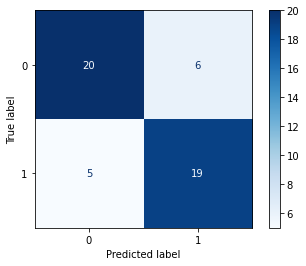

In [50]:
evaluate_model(best_logistic_reg_women, X_val_women, y_val_women, 'women')


In [95]:
cross_validation(best_logistic_reg_women, X_train_women, y_train_women, kf=kf)

Cross-Validation Accuracy Scores:
[0.78947368 0.88888889 0.94444444 0.83333333 0.94444444]
Mean CV Accuracy: 0.8801169590643274


Test set evaluation
Evaluation metrics for women:
Accuracy: 0.8333333333333334
Precision: 0.8666666666666667
Recall: 0.7647058823529411
F1 Score: 0.8125
ROC AUC Score: 0.8297213622291022


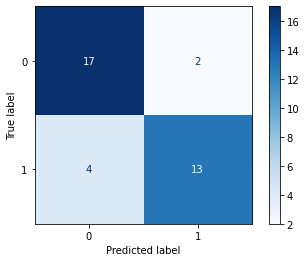

In [96]:
print('Test set evaluation')
evaluate_model(best_logistic_reg_women, X_test_women, y_test_women, 'women')

In [ ]:
# extract feature importances
#feature_importances = np.abs(best_logistic_reg.coef_).sum(axis=0)

#print("Feature Importances:")
#for importance, feature in sorted(zip(feature_importances, X_train_women.columns), reverse=True):
#    print(f"Feature {feature}: {importance}")

Logistic Regression for Men

In [51]:
logistic_reg = LogisticRegression(max_iter=1000, random_state=15, solver='liblinear')

grid_search = GridSearchCV(estimator=logistic_reg, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_men, y_train_men)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'C': 10, 'penalty': 'l1'}


In [52]:
best_logistic_reg_men = LogisticRegression(**best_params, solver='liblinear', max_iter=1000, random_state=15)
best_logistic_reg_men.fit(X_train_men, y_train_men)

LogisticRegression(C=10, max_iter=1000, penalty='l1', random_state=15,
                   solver='liblinear')

Evaluation metrics for men:
Accuracy: 0.9215686274509803
Precision: 0.875
Recall: 0.9545454545454546
F1 Score: 0.9130434782608695
ROC AUC Score: 0.9255485893416928


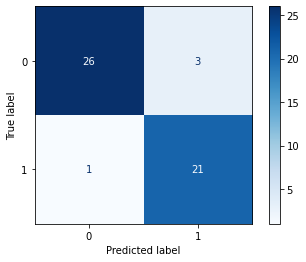

In [53]:
evaluate_model(best_logistic_reg_men, X_val_men, y_val_men, 'men')

In [97]:
cross_validation(best_logistic_reg_men, X_train_men, y_train_men, kf=kf)

Cross-Validation Accuracy Scores:
[0.94736842 0.94736842 1.         0.94444444 1.        ]
Mean CV Accuracy: 0.9678362573099415


Test set evaluation
Evaluation metrics for men:
Accuracy: 0.9166666666666666
Precision: 0.9285714285714286
Recall: 0.8666666666666667
F1 Score: 0.896551724137931
ROC AUC Score: 0.9095238095238095


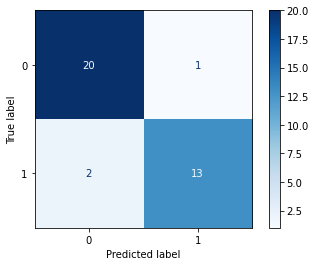

In [98]:
print('Test set evaluation')
evaluate_model(best_logistic_reg_men, X_test_men, y_test_men, 'men')

Random Forest

In [55]:
param_grid = {
    'n_estimators': [10, 20, 50, 100, 200],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['log2', 'sqrt']
}

Random Forest for Women

In [56]:
rf_classifier = RandomForestClassifier(random_state=15)

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_women, y_train_women)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}


In [57]:
best_rf_classifier_women = RandomForestClassifier(**best_params, random_state=15)
best_rf_classifier_women.fit(X_train_women, y_train_women)

RandomForestClassifier(criterion='entropy', max_features='log2',
                       min_samples_leaf=4, random_state=15)

Evaluation metrics for women:
Accuracy: 0.84
Precision: 0.8076923076923077
Recall: 0.875
F1 Score: 0.8400000000000001
ROC AUC Score: 0.8413461538461539


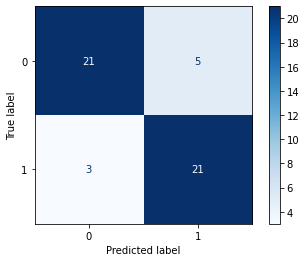

In [58]:
evaluate_model(best_rf_classifier_women, X_val_women, y_val_women, 'women')

In [99]:
cross_validation(best_rf_classifier_women, X_train_women, y_train_women, kf=kf)

Cross-Validation Accuracy Scores:
[0.73684211 0.77777778 0.88888889 0.94444444 0.88888889]
Mean CV Accuracy: 0.8473684210526315


Test set evaluation
Evaluation metrics for women:
Accuracy: 0.8888888888888888
Precision: 0.9333333333333333
Recall: 0.8235294117647058
F1 Score: 0.8749999999999999
ROC AUC Score: 0.8854489164086687


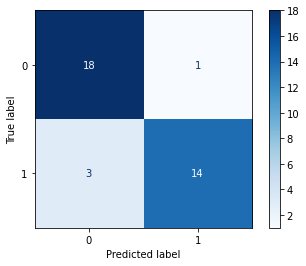

In [100]:
print('Test set evaluation')
evaluate_model(best_rf_classifier_women, X_test_women, y_test_women, 'women')

In [ ]:
#feature_importances = best_rf_classifier.feature_importances_
#for importance, feature in sorted(zip(feature_importances, X_train_women.columns), reverse=True):
#    print(f"Feature {feature}: {importance}")

Random Forest for Men

In [59]:
rf_classifier = RandomForestClassifier(random_state=15)

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_men, y_train_men)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [60]:
best_rf_classifier_men = RandomForestClassifier(**best_params, random_state=15)
best_rf_classifier_men.fit(X_train_men, y_train_men)

RandomForestClassifier(max_features='log2', n_estimators=200, random_state=15)

Evaluation metrics for men:
Accuracy: 0.9215686274509803
Precision: 0.8461538461538461
Recall: 1.0
F1 Score: 0.9166666666666666
ROC AUC Score: 0.9310344827586207


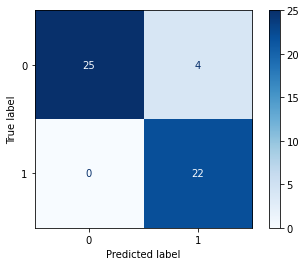

In [61]:
evaluate_model(best_rf_classifier_men, X_val_men, y_val_men, 'men')

In [101]:
cross_validation(best_rf_classifier_men, X_train_men, y_train_men, kf=kf)

Cross-Validation Accuracy Scores:
[0.89473684 0.89473684 0.88888889 0.83333333 1.        ]
Mean CV Accuracy: 0.9023391812865498


Test set evaluation
Evaluation metrics for men:
Accuracy: 0.9444444444444444
Precision: 0.8823529411764706
Recall: 1.0
F1 Score: 0.9375
ROC AUC Score: 0.9523809523809523


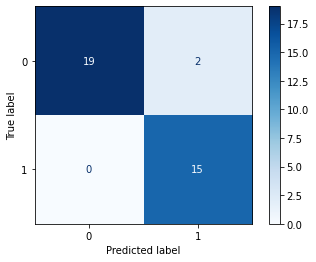

In [102]:
print('Test set evaluation')
evaluate_model(best_rf_classifier_men, X_test_men, y_test_men, 'men')

Decision Trees

In [62]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

Decision Trees for Women

In [63]:
dec_tree_classifier = DecisionTreeClassifier(random_state=15)

grid_search = GridSearchCV(estimator=dec_tree_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_women, y_train_women)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5}


In [64]:
best_dec_tree_classifier_women = DecisionTreeClassifier(**best_params, random_state=15)
best_dec_tree_classifier_women.fit(X_train_women, y_train_women)

DecisionTreeClassifier(max_depth=5, min_samples_split=5, random_state=15)

Evaluation metrics for women:
Accuracy: 0.68
Precision: 0.75
Recall: 0.5
F1 Score: 0.6
ROC AUC Score: 0.673076923076923


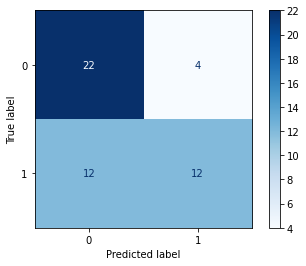

In [65]:
evaluate_model(best_dec_tree_classifier_women, X_val_women, y_val_women, 'women')

In [103]:
cross_validation(best_dec_tree_classifier_women, X_train_women, y_train_women, kf=kf)

Cross-Validation Accuracy Scores:
[0.57894737 0.83333333 0.72222222 0.94444444 0.77777778]
Mean CV Accuracy: 0.7713450292397661


Test set evaluation
Evaluation metrics for women:
Accuracy: 0.7777777777777778
Precision: 1.0
Recall: 0.5294117647058824
F1 Score: 0.6923076923076924
ROC AUC Score: 0.7647058823529411


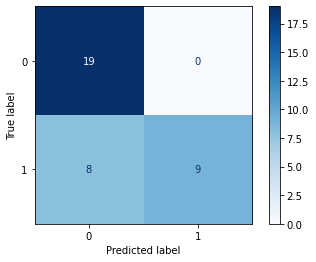

In [104]:
print('Test set evaluation')
evaluate_model(best_dec_tree_classifier_women, X_test_women, y_test_women, 'women')

Decision Trees for Men

In [66]:
dec_tree_classifier = DecisionTreeClassifier(random_state=15)

grid_search = GridSearchCV(estimator=dec_tree_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_men, y_train_men)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}


In [67]:
best_dec_tree_classifier_men = DecisionTreeClassifier(**best_params, random_state=15)
best_dec_tree_classifier_men.fit(X_train_men, y_train_men)

DecisionTreeClassifier(criterion='entropy', max_features='sqrt',
                       random_state=15)

Evaluation metrics for men:
Accuracy: 0.9019607843137255
Precision: 0.9047619047619048
Recall: 0.8636363636363636
F1 Score: 0.8837209302325582
ROC AUC Score: 0.8973354231974922


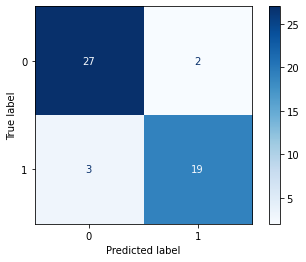

In [68]:
evaluate_model(best_dec_tree_classifier_men, X_val_men, y_val_men, 'men')

In [105]:
cross_validation(best_dec_tree_classifier_men, X_train_men, y_train_men, kf=kf)

Cross-Validation Accuracy Scores:
[0.84210526 0.84210526 0.77777778 0.77777778 0.88888889]
Mean CV Accuracy: 0.8257309941520468


Test set evaluation
Evaluation metrics for men:
Accuracy: 0.9166666666666666
Precision: 0.9285714285714286
Recall: 0.8666666666666667
F1 Score: 0.896551724137931
ROC AUC Score: 0.9095238095238095


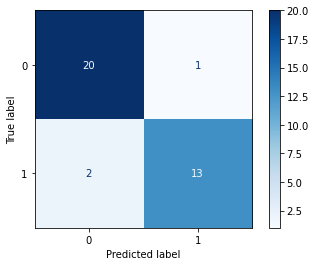

In [106]:
print('Test set evaluation')
evaluate_model(best_dec_tree_classifier_men, X_test_men, y_test_men, 'men')

Support Vector Machine (SVM)

In [69]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],  
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
    'kernel': ['rbf', 'poly', 'sigmoid']
}  

SVM for Women

In [70]:
svm = SVC(random_state=15)

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_women, y_train_women)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'C': 10, 'gamma': 0.001, 'kernel': 'sigmoid'}


In [71]:
best_svm_women = SVC(**best_params, random_state=15)
best_svm_women.fit(X_train_women, y_train_women)

SVC(C=10, gamma=0.001, kernel='sigmoid', random_state=15)

Evaluation metrics for women:
Accuracy: 0.82
Precision: 0.7419354838709677
Recall: 0.9583333333333334
F1 Score: 0.8363636363636364
ROC AUC Score: 0.8253205128205129


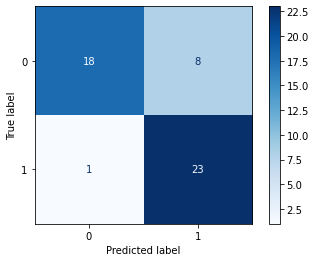

In [72]:
evaluate_model(best_svm_women, X_val_women, y_val_women, 'women')

In [107]:
cross_validation(best_svm_women, X_train_women, y_train_women, kf=kf)

Cross-Validation Accuracy Scores:
[0.78947368 0.88888889 0.83333333 0.94444444 0.88888889]
Mean CV Accuracy: 0.8690058479532162


Test set evaluation
Evaluation metrics for women:
Accuracy: 0.8888888888888888
Precision: 0.8421052631578947
Recall: 0.9411764705882353
F1 Score: 0.8888888888888888
ROC AUC Score: 0.891640866873065


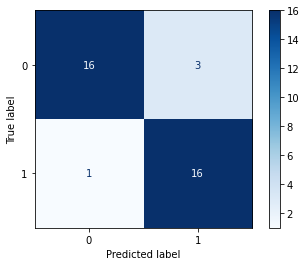

In [108]:
print('Test set evaluation')
evaluate_model(best_svm_women, X_test_women, y_test_women, 'women')

In [ ]:
#perm_importance = permutation_importance(best_svm, X_train_women, y_train_women, n_repeats=10, random_state=15)
#feature_importance_scores = perm_importance.importances_mean
#for importance, feature in sorted(zip(feature_importance_scores, X_train_women.columns), reverse=True):
#    print(f"Feature {feature}: {importance}")

SVM for Men

In [73]:
svm = SVC(random_state=15)

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_men, y_train_men)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


In [74]:
best_svm_men = SVC(**best_params, random_state=15)
best_svm_men.fit(X_train_men, y_train_men)

SVC(C=100, gamma=0.01, random_state=15)

Evaluation metrics for men:
Accuracy: 0.9215686274509803
Precision: 0.875
Recall: 0.9545454545454546
F1 Score: 0.9130434782608695
ROC AUC Score: 0.9255485893416928


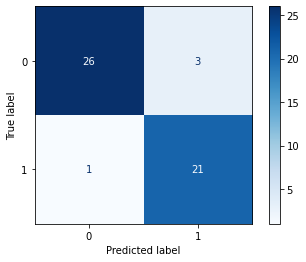

In [75]:
evaluate_model(best_svm_men, X_val_men, y_val_men, 'men')

In [109]:
cross_validation(best_svm_men, X_train_men, y_train_men, kf=kf)

Cross-Validation Accuracy Scores:
[0.94736842 0.94736842 0.94444444 0.94444444 1.        ]
Mean CV Accuracy: 0.9567251461988304


Test set evaluation
Evaluation metrics for men:
Accuracy: 0.9166666666666666
Precision: 0.875
Recall: 0.9333333333333333
F1 Score: 0.9032258064516129
ROC AUC Score: 0.919047619047619


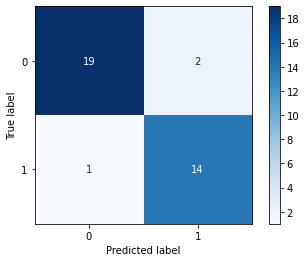

In [110]:
print('Test set evaluation')
evaluate_model(best_svm_men, X_test_men, y_test_men, 'men')

K-Nearest Neighbours

In [76]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9],     
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

K-Nearest Neighbours for Women

In [77]:
knn_classifier = KNeighborsClassifier()

grid_search = GridSearchCV(estimator=knn_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_women, y_train_women)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}


In [78]:
best_knn_classifier_women = KNeighborsClassifier(**best_params)
best_knn_classifier_women.fit(X_train_women, y_train_women)

KNeighborsClassifier(metric='euclidean')

Evaluation metrics for women:
Accuracy: 0.88
Precision: 0.8214285714285714
Recall: 0.9583333333333334
F1 Score: 0.8846153846153847
ROC AUC Score: 0.8830128205128206


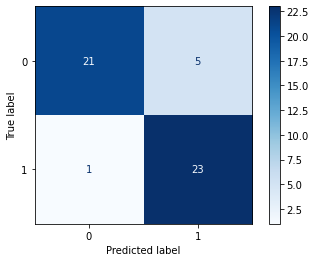

In [79]:
evaluate_model(best_knn_classifier_women, X_val_women, y_val_women, 'women')

In [111]:
cross_validation(best_knn_classifier_women, X_train_women, y_train_women, kf=kf)

Cross-Validation Accuracy Scores:
[0.78947368 0.88888889 0.88888889 0.94444444 0.72222222]
Mean CV Accuracy: 0.8467836257309942


Test set evaluation
Evaluation metrics for women:
Accuracy: 0.9166666666666666
Precision: 0.9375
Recall: 0.8823529411764706
F1 Score: 0.9090909090909091
ROC AUC Score: 0.9148606811145512


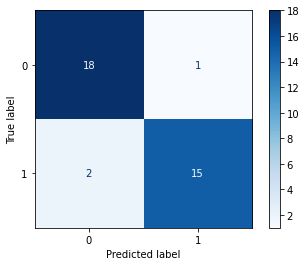

In [112]:
print('Test set evaluation')
evaluate_model(best_knn_classifier_women, X_test_women, y_test_women, 'women')

K-Nearest Neighbours for Men

In [80]:
knn_classifier = KNeighborsClassifier()

grid_search = GridSearchCV(estimator=knn_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_men, y_train_men)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


In [81]:
best_knn_classifier_men = KNeighborsClassifier(**best_params)
best_knn_classifier_men.fit(X_train_men, y_train_men)

KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')

Evaluation metrics for men:
Accuracy: 0.9215686274509803
Precision: 0.875
Recall: 0.9545454545454546
F1 Score: 0.9130434782608695
ROC AUC Score: 0.9255485893416928


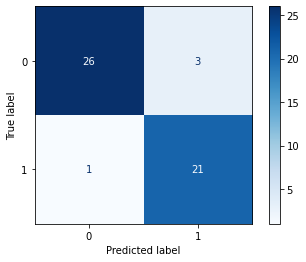

In [82]:
evaluate_model(best_knn_classifier_men, X_val_men, y_val_men, 'men')

In [113]:
cross_validation(best_knn_classifier_men, X_train_men, y_train_men, kf=kf)

Cross-Validation Accuracy Scores:
[0.84210526 0.89473684 0.88888889 0.77777778 0.88888889]
Mean CV Accuracy: 0.8584795321637426


Test set evaluation
Evaluation metrics for men:
Accuracy: 0.9166666666666666
Precision: 0.8333333333333334
Recall: 1.0
F1 Score: 0.9090909090909091
ROC AUC Score: 0.9285714285714286


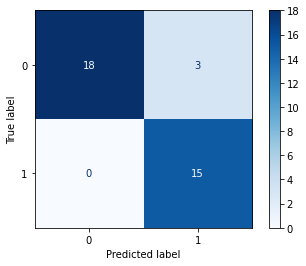

In [114]:
print('Test set evaluation')
evaluate_model(best_knn_classifier_men, X_test_men, y_test_men, 'men')